In [1]:
import nldi_xstool
%matplotlib inline
from nldi_xstool.XSGen import XSGen
from nldi_xstool.ancillary import query_dems_bbox
import py3dep
from pynhd import NLDI, NHDPlusHR, WaterData
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import dataretrieval.nwis as nwis

import ee # Google Earth Engine

/home/sarah/anaconda3/envs/py39/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Use NWIS data to get days of high discharge from gage locations

getSiteData uses NWIS to get data about a registered data collection location with a stream gage.

In [2]:
def getSiteData(site_number, start_date, end_date):
    measurements = nwis.get_record(sites=site_number, service='measurements')
    site_info = nwis.get_record(sites=site_number, service='site')
    instantaneous_discharge = nwis.get_record(sites=site_number, service='iv', start=start_date, end=end_date)
    daily_discharge = nwis.get_record(sites=site_number, service='dv', start=start_date, end=end_date)
    peak_discharge = nwis.get_record(sites=site_number, service='peaks', start=start_date, end=end_date)
    return [measurements, site_info, instantaneous_discharge, daily_discharge, peak_discharge]

getDailyDischargeFromSite gets just the daily discharge data based on the selected site.

In [3]:
def getDailyDischargeFromSite(site_number, start_date, end_date):
    return nwis.get_record(sites=site_number, service='dv', start=start_date, end=end_date)

getDailyDischargeValuesAboveThreshold returns the dataframe rows form the NWIS daily discharge dataset that are above a given discharge threshold. This function optionally displays a graph of the results.

In [4]:
def getDailyDischargeValuesAboveThreshold(daily_discharge, discharge_cfs_threshold, plot_dates = True): 
    threshold_met = daily_discharge.loc[daily_discharge['00060_Mean'] >= discharge_cfs_threshold]
    
    # optional plotting of dates
    if(plot_dates):
        fig, ax = plt.subplots()
        ax.scatter(x= threshold_met.index, y=threshold_met['00060_Mean'])
        title_text = "Daily Mean Discharge Values Above "+str(discharge_cfs_threshold)+" cfs"
        ax.set_title(title_text)
        ax.set_xlabel("Dates")
        ax.set_ylabel("Discharge")
        plt.xticks(rotation = 45)
        plt.show()
        
    return threshold_met

reformatDatesForGoogleEarthEngine formats the dates from the NWIS datafram so that they can be used in Google Earth Engine

In [5]:
def reformatDatesForGoogleEarthEngine(discharge_threshold_met_dataframe):
    dates = [ time.strftime("%Y-%m-%d") for time in discharge_threshold_met_dataframe.index.tolist()]
    return dates

getDatesAboveDischargeThreshold combines the above functions into one call

In [6]:
def getDatesAboveDischargeThreshold(site_number, start_date, end_date, discharge_cfs_threshold, plot_dates = True):
    # get data for site by site number
    daily_discharge = getDailyDischargeFromSite(site_number, start_date, end_date)
    
    # get dataframe values for given discharge threshold
    discharge_threshold_met_dataframe = getDailyDischargeValuesAboveThreshold(daily_discharge, discharge_cfs_threshold, plot_dates)
    
    # return the dates in Google Earth Engine format
    return reformatDatesForGoogleEarthEngine(discharge_threshold_met_dataframe)

Case 1: Matilija

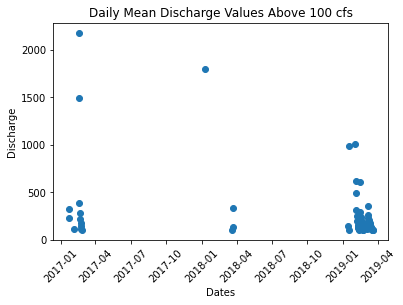

In [7]:
matilija_site_number='11114495'
start_date = '2014-12-31'
end_date = '2020-01-01'
matilija_discharge_cfs_threshold = 100

matilija_dates_above_threshold = getDatesAboveDischargeThreshold(matilija_site_number, start_date, end_date, 
                                                                 matilija_discharge_cfs_threshold)

In [8]:
print(matilija_dates_above_threshold)

['2017-01-22', '2017-01-23', '2017-02-06', '2017-02-17', '2017-02-18', '2017-02-19', '2017-02-20', '2017-02-21', '2017-02-22', '2017-02-23', '2017-02-24', '2017-02-25', '2018-01-09', '2018-03-21', '2018-03-22', '2018-03-23', '2019-01-15', '2019-01-17', '2019-01-18', '2019-02-02', '2019-02-03', '2019-02-04', '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09', '2019-02-10', '2019-02-11', '2019-02-12', '2019-02-13', '2019-02-14', '2019-02-15', '2019-02-16', '2019-02-17', '2019-02-18', '2019-02-19', '2019-02-20', '2019-02-21', '2019-02-22', '2019-02-23', '2019-03-02', '2019-03-03', '2019-03-04', '2019-03-05', '2019-03-06', '2019-03-07', '2019-03-08', '2019-03-09', '2019-03-10', '2019-03-11', '2019-03-12', '2019-03-13', '2019-03-14', '2019-03-15', '2019-03-16', '2019-03-17', '2019-03-18', '2019-03-19', '2019-03-20']


Case 2: Willamette River at Harrisburg, OR

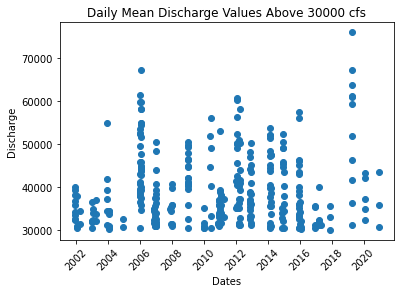

In [9]:
willamette_site_number='14166000'
start_date = '2001-10-01'
end_date = '2021-09-30'
willamette_discharge_cfs_threshold = 30000

willamette_dates_above_threshold = getDatesAboveDischargeThreshold(willamette_site_number, start_date, end_date, 
                                                                 willamette_discharge_cfs_threshold)

In [10]:
print(willamette_dates_above_threshold)

['2001-12-07', '2001-12-14', '2001-12-15', '2001-12-17', '2001-12-18', '2001-12-19', '2001-12-20', '2001-12-21', '2001-12-22', '2002-01-22', '2002-01-26', '2002-01-27', '2002-04-15', '2002-04-16', '2002-12-31', '2003-01-01', '2003-01-03', '2003-01-04', '2003-01-05', '2003-01-31', '2003-02-01', '2003-02-02', '2003-03-26', '2003-03-27', '2003-03-28', '2003-12-14', '2003-12-15', '2003-12-16', '2003-12-17', '2003-12-18', '2003-12-19', '2004-01-25', '2004-01-29', '2004-01-31', '2004-02-01', '2004-02-02', '2004-02-03', '2004-12-10', '2004-12-12', '2005-12-29', '2005-12-30', '2005-12-31', '2006-01-01', '2006-01-02', '2006-01-03', '2006-01-04', '2006-01-05', '2006-01-06', '2006-01-07', '2006-01-08', '2006-01-09', '2006-01-10', '2006-01-11', '2006-01-12', '2006-01-13', '2006-01-14', '2006-01-15', '2006-01-16', '2006-01-17', '2006-01-18', '2006-01-19', '2006-01-20', '2006-01-21', '2006-01-22', '2006-01-23', '2006-01-24', '2006-01-25', '2006-01-26', '2006-01-27', '2006-01-28', '2006-01-29', '2006

Case 3: Mississippi River at Vicksburg, MS

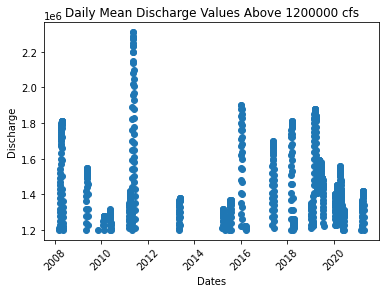

In [11]:
mississippi_site_number='07289000'
start_date = '2001-10-01'
end_date = '2021-09-30'
mississippi_discharge_cfs_threshold = 1200000

mississippi_dates_above_threshold = getDatesAboveDischargeThreshold(mississippi_site_number, start_date, end_date, 
                                                                 mississippi_discharge_cfs_threshold)

In [12]:
print(mississippi_dates_above_threshold)

['2008-03-16', '2008-03-17', '2008-03-18', '2008-03-19', '2008-03-20', '2008-03-21', '2008-03-22', '2008-03-23', '2008-03-24', '2008-03-25', '2008-03-26', '2008-03-27', '2008-03-28', '2008-03-29', '2008-03-30', '2008-03-31', '2008-04-01', '2008-04-02', '2008-04-03', '2008-04-04', '2008-04-05', '2008-04-06', '2008-04-07', '2008-04-08', '2008-04-09', '2008-04-10', '2008-04-11', '2008-04-12', '2008-04-13', '2008-04-14', '2008-04-15', '2008-04-16', '2008-04-17', '2008-04-18', '2008-04-19', '2008-04-20', '2008-04-21', '2008-04-22', '2008-04-23', '2008-04-24', '2008-04-25', '2008-04-26', '2008-04-27', '2008-04-28', '2008-04-29', '2008-04-30', '2008-05-01', '2008-05-02', '2008-05-03', '2008-05-04', '2008-05-05', '2008-05-06', '2008-05-07', '2008-05-08', '2008-05-09', '2008-05-10', '2008-05-11', '2009-05-09', '2009-05-10', '2009-05-11', '2009-05-12', '2009-05-13', '2009-05-14', '2009-05-15', '2009-05-16', '2009-05-17', '2009-05-18', '2009-05-19', '2009-05-20', '2009-05-21', '2009-05-22', '2009

Now, we want to take to above dates and run them in Google Earth Engine. The below code gets a verification token to authenticate the user.

## Mapping dates with Google Earth Engine

In [13]:
ee.Authenticate()

Enter verification code: 4/1AX4XfWjdqIymxGxvgx0EuEl-MbM9oRg90VuB8IW9XKmXeH5sBF86DNPXbsE

Successfully saved authorization token.


In [14]:
ee.Initialize()

In [58]:
# grometry and imports
sentinel2 = ee.ImageCollection("COPERNICUS/S2")
willametteGageLocation = ee.Geometry.Point([-123.17358217907135, 44.270577824809386])
landsat8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_TOA")
mississippiGageLocation = ee.Geometry.Point([-90.90767631543106, 32.329061036323516])
willametteGeometry = ee.Geometry.Polygon(
        [[[-123.17735227170873, 44.27870641979654],
          [-123.17670854154515, 44.27683214434244],
          [-123.17606481138158, 44.27418962165109],
          [-123.17559274259496, 44.27004123588735],
          [-123.17585023466039, 44.26739840782829],
          [-123.17353280607152, 44.26638426783975],
          [-123.17353280607152, 44.2703178040482],
          [-123.17404779020238, 44.2746812627772],
          [-123.17400487485814, 44.27566453269001],
          [-123.17516358915258, 44.27855279291034],
          [-123.175421081218, 44.279136572940985]]]);
matilijaGeometry = ee.Geometry.Polygon(
        [[[-119.31594286538936, 34.49174896054574],
          [-119.31594286538936, 34.48219820073181],
          [-119.30285368539668, 34.48219820073181],
          [-119.30285368539668, 34.49174896054574]]], None, False);

Helper functions to use ee

In [31]:
# interactive map for images
import geemap

mapColor = ['45a248', '1c3da2']

In [17]:
from datetime import datetime
from datetime import timedelta

def dateToString(date):
    start_date = datetime.strptime(date, "%Y-%m-%d")
    end_date = start_date + timedelta(days=1)
    return [start_date.strftime("%Y-%m-%d"), end_date.strftime("%Y-%m-%d")]

In [18]:
# get the image collection of all images from the dates passes
def getListOfImages(datesList, location, satellite):
    images = []
  
    for date in datesList:
        # get the day number in the year of the date so we can look
        # it up 
        searchDates = dateToString(date)
    
        # get image form given date with least cloud cover
        
        satelliteImageForDate = ee.ImageCollection(satellite) \
        .filterBounds(location) \
        .filterDate(searchDates[0], searchDates[1]) \
        .sort('CLOUD_COVER') \
        .first()

        # when the image is not null we want to add it to our list of 
        # images
        if (satelliteImageForDate):
            images.append(satelliteImageForDate)


    # turn images found into a collection so we can map them
    collectionFromImages = ee.ImageCollection.fromImages(images)

    
    # filter image on clouds on pick geometry location
    filtered = collectionFromImages.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
        .filter(ee.Filter.bounds(location))
    return filtered
    


In [29]:
# map the image collection 
def mapImageCollection(imageCollection):
    Map = geemap.Map()
    image = imageCollection.first()

    vis_param = {'min': 0, 
                 'max': 2000, 
                 'bands': ['B5', 'B4', 'B3'], 
                 'gamma': 1.5}
    Map.addLayer(image, vis_param, "First mage")
    Map.centerObject(image, 8)    
   
    mosaic = imageCollection.mosaic()

    medianComposite = imageCollection.median()
    
    rgbVis = {
        'min': 0.0,
        'max': 3000,
        'bands': ['B4', 'B3', 'B2'],
    }

    Map.addLayer(imageCollection, rgbVis, 'Filtered Collection');
    Map.addLayer(mosaic, rgbVis, 'Mosaic');
    Map.addLayer(medianComposite, rgbVis, 'Median Composite')

    normDiffOnMedComp = medianComposite.normalizedDifference(['B3', 'B5'])
    water = normDiffOnMedComp.gt(0)
    Map.addLayer(water, {'min': 0, 'max':1, 'palette': mapColor}, "ndwiMosaic")
    return Map

In [81]:
# map a single ndwi image from a given date
def mapImageFromDate(date, location, satellite):
    Map = geemap.Map()
    dateRange = dateToString(date)
    image = satellite \
      .filterBounds(location) \
      .filterDate(dateRange[0], dateRange[1]) \
      .sort('CLOUD_COVER') \
      .first()
    
    #Map.addLayer(image, {'bands': ['B4', 'B3', 'B2'], 'min':0, 'max': 0.3})

    ndwi = image.normalizedDifference(['B3', 'B5'])
    #Map.addLayer(ndwi, {'min':-1, 'max':1, 'palette': mapColor})

    water = ndwi.gt(0)

    Map.addLayer(water, {'min': 0, 'max':1, 'palette': mapColor})
    
    reducer = image.reduceRegion( reducer= ee.Reducer.mean(), geometry= water.geometry().getInfo(), scale= 30, maxPixels= 1e13 )
    print(reducer.getInfo())
    scale = 30
    area = ee.Number(reducer.get('NDVI')).multiply(scale).multiply(scale).divide(1000000);
    # gives an area of 147502.63 km2
    print('area of Riyadh: ', area.getInfo() + ' km2');
    
    return Map

In [21]:
# get all dates that returned an image in the image collection
def getDatesFromImageCollection(imageCollection):
    dates = []
    for feature in collection.getInfo()['features']:
        ms = feature['properties']['system:time_start']
        dateOfImage = datetime.fromtimestamp(ms/1000.0).strftime("%Y-%m-%d")
        dates.append(dateOfImage)
    return dates

In [59]:
matilijaGageLocation = ee.Geometry.Point(-119.30795921344384, 34.48573359710931)
collection = getListOfImages(matilija_dates_above_threshold, matilijaGeometry, sentinel2)
Map = mapImageCollection(collection)
lat = 34.48573359710931
lon = -119.30795921344384
zoom = 15
Map.setCenter(lon, lat, zoom)
Map

Map(center=[34.48573359710931, -119.30795921344384], controls=(WidgetControl(options=['position', 'transparent…

In [60]:
getDatesFromImageCollection(collection)

['2019-02-06', '2019-02-08', '2019-02-23', '2019-03-13', '2019-03-18']

In [82]:
Map = mapImageFromDate('2019-02-08', matilijaGeometry, sentinel2)
lat = 34.48573359710931
lon = -119.30795921344384
zoom = 15
Map.setCenter(lon, lat, zoom)
Map

{'B1': 1502.7760656960609, 'B10': 49.28673742232786, 'B11': 1701.1293405834738, 'B12': 1192.3139508051224, 'B2': 1228.337978824155, 'B3': 1103.773850133918, 'B4': 1006.814193237006, 'B5': 1244.4609542464627, 'B6': 1825.108024954673, 'B7': 2016.3770611714108, 'B8': 2016.399537322778, 'B8A': 2151.66333538969, 'B9': 1180.5111130503408, 'QA10': 0, 'QA20': 0, 'QA60': 34.95341395682164}


EEException: Dictionary.get: Dictionary does not contain key: NDVI.

## Getting area of water shown on map

Working on getting image white amount from a cleaner image

In [78]:
matilijaLandsat = mapImageFromDate('2017-04-29', matilijaGageLocation, landsat8)
lat = 34.48573359710931
lon = -119.30795921344384
zoom = 15
matilijaLandsat.setCenter(lon, lat, zoom)
matilijaLandsat

EEException: Image.reduceRegion: Too many pixels in the region. Found 1059824047, but maxPixels allows only 1000000000.
Ensure that you are not aggregating at a higher resolution than you intended; that is a frequent cause of this error. If not, then you may set the 'maxPixels' argument to a limit suitable for your computation; set 'bestEffort' to true to aggregate at whatever scale results in 'maxPixels' total pixels; or both.

In [49]:
countries = ee.FeatureCollection('ft:1tdSwUL7MVpOauSgRzqVTOwdfy17KDbw-1d9omPw');
Nepal = countries.filterMetadata('Country', 'equals', 'Nepal');
scaleforTestArea = 30;

# km square
img = matilijaLandsat.pixelArea().divide(1000000);

area2 = img.reduceRegion({
  'reducer': ee.Reducer.sum(),
  'geometry': Nepal,
  'crs': 'EPSG:32645',  # WGS Zone N 45
  'scale': scaleforTestArea,
  'maxPixels': 1E13
})
# gives an area of 147134.49 km2
print('area of Nepal using pixel area method: ', ee.Number(area2.get('area')).getInfo() + ' km2');

AttributeError: 'Map' object has no attribute 'pixelArea'

In [26]:
#var willametteFilterDates = ['2001-12-07', '2001-12-14', '2001-12-15', '2001-12-17', '2001-12-18', '2001-12-19', '2001-12-20', '2001-12-21', '2001-12-22', '2002-01-22', '2002-01-26', '2002-01-27', '2002-04-15', '2002-04-16', '2002-12-31', '2003-01-01', '2003-01-03', '2003-01-04', '2003-01-05', '2003-01-31', '2003-02-01', '2003-02-02', '2003-03-26', '2003-03-27', '2003-03-28', '2003-12-14', '2003-12-15', '2003-12-16', '2003-12-17', '2003-12-18', '2003-12-19', '2004-01-25', '2004-01-29', '2004-01-31', '2004-02-01', '2004-02-02', '2004-02-03', '2004-12-10', '2004-12-12', '2005-12-29', '2005-12-30', '2005-12-31', '2006-01-01', '2006-01-02', '2006-01-03', '2006-01-04', '2006-01-05', '2006-01-06', '2006-01-07', '2006-01-08', '2006-01-09', '2006-01-10', '2006-01-11', '2006-01-12', '2006-01-13', '2006-01-14', '2006-01-15', '2006-01-16', '2006-01-17', '2006-01-18', '2006-01-19', '2006-01-20', '2006-01-21', '2006-01-22', '2006-01-23', '2006-01-24', '2006-01-25', '2006-01-26', '2006-01-27', '2006-01-28', '2006-01-29', '2006-01-30', '2006-01-31', '2006-02-01', '2006-02-02', '2006-02-03', '2006-02-04', '2006-02-05', '2006-02-06', '2006-11-23', '2006-11-24', '2006-11-25', '2006-11-26', '2006-11-27', '2006-12-14', '2006-12-15', '2006-12-17', '2006-12-18', '2006-12-19', '2006-12-24', '2006-12-25', '2006-12-26', '2006-12-27', '2006-12-28', '2006-12-29', '2006-12-30', '2006-12-31', '2007-01-01', '2007-01-02', '2007-01-03', '2007-01-04', '2007-01-05', '2007-01-09', '2007-01-10', '2007-01-11', '2007-11-19', '2007-12-24', '2007-12-25', '2007-12-26', '2008-01-09', '2008-01-11', '2008-01-12', '2008-01-13', '2008-01-14', '2008-01-15', '2008-12-29', '2008-12-30', '2008-12-31', '2009-01-01', '2009-01-02', '2009-01-03', '2009-01-04', '2009-01-05', '2009-01-06', '2009-01-07', '2009-01-08', '2009-01-09', '2009-01-10', '2009-01-11', '2009-01-12', '2009-01-13', '2009-01-14', '2009-01-15', '2010-01-02', '2010-01-06', '2010-01-07', '2010-01-08', '2010-01-09', '2010-06-03', '2010-06-04', '2010-06-05', '2010-06-06', '2010-06-07', '2010-06-08', '2010-06-09', '2010-12-02', '2010-12-03', '2010-12-14', '2010-12-15', '2010-12-16', '2010-12-17', '2010-12-18', '2010-12-19', '2010-12-20', '2010-12-21', '2010-12-22', '2010-12-23', '2010-12-29', '2010-12-30', '2011-01-16', '2011-01-17', '2011-01-18', '2011-01-19', '2011-01-20', '2011-01-21', '2011-01-22', '2011-01-23', '2011-01-24', '2011-01-25', '2011-04-17', '2011-04-18', '2011-12-31', '2012-01-19', '2012-01-20', '2012-01-21', '2012-01-22', '2012-01-23', '2012-01-24', '2012-01-25', '2012-01-26', '2012-01-27', '2012-01-28', '2012-01-29', '2012-01-30', '2012-01-31', '2012-03-16', '2012-03-17', '2012-03-18', '2012-03-21', '2012-03-22', '2012-03-23', '2012-03-24', '2012-03-25', '2012-03-29', '2012-03-30', '2012-03-31', '2012-04-01', '2012-04-02', '2012-04-03', '2012-04-04', '2012-04-05', '2012-04-06', '2012-11-21', '2012-11-22', '2012-11-23', '2012-11-24', '2012-11-25', '2012-11-26', '2012-11-27', '2012-11-28', '2012-11-29', '2012-11-30', '2012-12-01', '2012-12-02', '2012-12-03', '2012-12-04', '2012-12-05', '2012-12-06', '2012-12-07', '2012-12-08', '2012-12-09', '2012-12-10', '2012-12-11', '2012-12-12', '2012-12-18', '2014-02-12', '2014-02-13', '2014-02-14', '2014-02-15', '2014-02-16', '2014-02-17', '2014-02-18', '2014-02-19', '2014-02-20', '2014-02-21', '2014-02-22', '2014-02-23', '2014-02-24', '2014-02-25', '2014-03-04', '2014-03-05', '2014-03-06', '2014-03-07', '2014-03-08', '2014-03-09', '2014-03-10', '2014-03-11', '2014-03-12', '2014-03-13', '2014-03-14', '2014-11-29', '2014-11-30', '2014-12-02', '2014-12-03', '2014-12-21', '2014-12-22', '2014-12-23', '2014-12-24', '2014-12-25', '2014-12-26', '2014-12-27', '2014-12-28', '2014-12-29', '2014-12-30', '2014-12-31', '2015-01-01', '2015-01-02', '2015-01-03', '2015-12-11', '2015-12-12', '2015-12-13', '2015-12-14', '2015-12-15', '2015-12-16', '2015-12-17', '2015-12-18', '2015-12-19', '2015-12-20', '2015-12-21', '2015-12-22', '2015-12-23', '2015-12-24', '2015-12-25', '2015-12-26', '2015-12-27', '2015-12-28', '2015-12-29', '2016-01-18', '2016-01-20', '2016-01-21', '2016-01-22', '2016-01-23', '2016-01-30', '2016-12-15', '2016-12-16', '2016-12-17', '2016-12-21', '2017-02-22', '2017-03-09', '2017-03-10', '2017-03-11', '2017-03-16', '2017-03-17', '2017-03-19', '2017-04-27', '2017-11-24', '2017-11-25', '2017-11-26', '2019-04-08', '2019-04-09', '2019-04-10', '2019-04-11', '2019-04-12', '2019-04-13', '2019-04-14', '2019-04-15', '2019-04-16', '2019-04-17', '2019-04-18', '2020-01-28', '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01', '2020-12-21', '2020-12-22', '2020-12-23'];
#mapDates(willametteFilterDates, willametteGeometry, sentinel2);

In [27]:
#var mississippiFilterDates = ['2008-03-16', '2008-03-17', '2008-03-18', '2008-03-19', '2008-03-20', '2008-03-21', '2008-03-22', '2008-03-23', '2008-03-24', '2008-03-25', '2008-03-26', '2008-03-27', '2008-03-28', '2008-03-29', '2008-03-30', '2008-03-31', '2008-04-01', '2008-04-02', '2008-04-03', '2008-04-04', '2008-04-05', '2008-04-06', '2008-04-07', '2008-04-08', '2008-04-09', '2008-04-10', '2008-04-11', '2008-04-12', '2008-04-13', '2008-04-14', '2008-04-15', '2008-04-16', '2008-04-17', '2008-04-18', '2008-04-19', '2008-04-20', '2008-04-21', '2008-04-22', '2008-04-23', '2008-04-24', '2008-04-25', '2008-04-26', '2008-04-27', '2008-04-28', '2008-04-29', '2008-04-30', '2008-05-01', '2008-05-02', '2008-05-03', '2008-05-04', '2008-05-05', '2008-05-06', '2008-05-07', '2008-05-08', '2008-05-09', '2008-05-10', '2008-05-11', '2009-05-09', '2009-05-10', '2009-05-11', '2009-05-12', '2009-05-13', '2009-05-14', '2009-05-15', '2009-05-16', '2009-05-17', '2009-05-18', '2009-05-19', '2009-05-20', '2009-05-21', '2009-05-22', '2009-05-23', '2009-05-24', '2009-05-25', '2009-05-26', '2009-05-27', '2009-05-28', '2009-05-29', '2009-05-30', '2009-05-31', '2009-06-01', '2009-06-02', '2009-06-03', '2009-06-04', '2009-06-05', '2009-11-11', '2010-02-05', '2010-02-06', '2010-02-07', '2010-02-08', '2010-02-09', '2010-02-10', '2010-02-11', '2010-02-12', '2010-02-13', '2010-02-14', '2010-02-15', '2010-02-16', '2010-02-17', '2010-02-18', '2010-02-19', '2010-05-14', '2010-05-15', '2010-05-16', '2010-05-17', '2010-05-18', '2010-05-19', '2010-05-20', '2010-05-21', '2010-05-22', '2010-05-23', '2010-05-24', '2010-05-25', '2010-05-26', '2010-05-27', '2010-05-28', '2010-05-29', '2010-05-30', '2010-05-31', '2010-06-01', '2011-03-13', '2011-03-14', '2011-03-15', '2011-03-16', '2011-03-17', '2011-03-18', '2011-03-19', '2011-03-20', '2011-03-21', '2011-03-22', '2011-03-23', '2011-03-24', '2011-03-25', '2011-03-26', '2011-03-27', '2011-03-28', '2011-03-29', '2011-03-30', '2011-03-31', '2011-04-01', '2011-04-02', '2011-04-03', '2011-04-04', '2011-04-05', '2011-04-06', '2011-04-07', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-29', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-03', '2011-05-04', '2011-05-05', '2011-05-06', '2011-05-07', '2011-05-08', '2011-05-09', '2011-05-10', '2011-05-11', '2011-05-12', '2011-05-13', '2011-05-14', '2011-05-15', '2011-05-16', '2011-05-17', '2011-05-18', '2011-05-19', '2011-05-20', '2011-05-21', '2011-05-22', '2011-05-23', '2011-05-24', '2011-05-25', '2011-05-26', '2011-05-27', '2011-05-28', '2011-05-29', '2011-05-30', '2011-05-31', '2011-06-01', '2011-06-02', '2011-06-03', '2011-06-04', '2011-06-05', '2011-06-06', '2011-06-07', '2011-06-08', '2011-06-09', '2011-06-10', '2011-06-11', '2011-06-12', '2011-06-13', '2011-06-14', '2013-05-02', '2013-05-03', '2013-05-04', '2013-05-05', '2013-05-06', '2013-05-07', '2013-05-08', '2013-05-09', '2013-05-10', '2013-05-11', '2013-05-12', '2013-05-13', '2013-05-14', '2013-05-15', '2013-05-16', '2013-05-17', '2013-05-18', '2013-05-19', '2013-05-20', '2013-05-21', '2013-05-22', '2013-05-23', '2013-05-24', '2013-05-25', '2013-05-26', '2013-05-27', '2015-03-22', '2015-03-23', '2015-03-24', '2015-03-25', '2015-03-26', '2015-03-27', '2015-03-28', '2015-03-29', '2015-03-30', '2015-03-31', '2015-04-01', '2015-04-02', '2015-04-03', '2015-04-04', '2015-04-05', '2015-04-06', '2015-04-26', '2015-04-27', '2015-04-28', '2015-04-29', '2015-04-30', '2015-05-01', '2015-05-02', '2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11', '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15', '2015-07-16', '2015-07-17', '2015-07-18', '2015-07-19', '2015-07-20', '2015-07-21', '2015-07-22', '2015-07-23', '2015-07-24', '2015-07-25', '2015-07-26', '2015-07-27', '2015-07-28', '2015-07-29', '2015-07-30', '2015-07-31', '2015-08-01', '2015-08-02', '2015-08-03', '2015-08-04', '2015-08-05', '2015-12-31', '2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08', '2016-01-09', '2016-01-10', '2016-01-11', '2016-01-12', '2016-01-13', '2016-01-14', '2016-01-15', '2016-01-16', '2016-01-17', '2016-01-18', '2016-01-19', '2016-01-20', '2016-01-21', '2016-01-22', '2016-01-23', '2016-01-24', '2016-01-25', '2016-01-26', '2016-01-27', '2016-01-28', '2016-03-14', '2016-03-15', '2016-03-16', '2016-03-17', '2016-03-18', '2016-03-19', '2016-03-20', '2016-03-21', '2017-05-06', '2017-05-07', '2017-05-08', '2017-05-09', '2017-05-10', '2017-05-11', '2017-05-12', '2017-05-13', '2017-05-14', '2017-05-15', '2017-05-16', '2017-05-17', '2017-05-18', '2017-05-19', '2017-05-20', '2017-05-21', '2017-05-22', '2017-05-23', '2017-05-24', '2017-05-25', '2017-05-26', '2017-05-27', '2017-05-28', '2017-05-29', '2017-05-30', '2017-05-31', '2017-06-01', '2017-06-02', '2017-06-03', '2017-06-04', '2017-06-05', '2017-06-06', '2017-06-07', '2017-06-08', '2017-06-09', '2017-06-10', '2017-06-11', '2017-06-12', '2018-02-26', '2018-02-27', '2018-02-28', '2018-03-01', '2018-03-02', '2018-03-03', '2018-03-04', '2018-03-05', '2018-03-06', '2018-03-07', '2018-03-08', '2018-03-09', '2018-03-10', '2018-03-11', '2018-03-12', '2018-03-13', '2018-03-14', '2018-03-15', '2018-03-16', '2018-03-17', '2018-03-18', '2018-03-19', '2018-03-20', '2018-03-21', '2018-03-22', '2018-03-23', '2018-03-24', '2018-03-25', '2018-03-26', '2018-03-27', '2018-03-28', '2018-03-29', '2018-03-30', '2018-04-04', '2018-04-05', '2018-04-06', '2018-04-07', '2018-04-08', '2018-04-09', '2018-04-10', '2018-04-11', '2018-04-12', '2018-04-13', '2018-04-14', '2018-04-15', '2018-04-16', '2018-04-17', '2018-04-18', '2018-04-19', '2018-04-20', '2018-04-21', '2018-04-22', '2018-04-23', '2018-04-24', '2018-04-25', '2018-04-26', '2019-01-07', '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11', '2019-01-12', '2019-01-13', '2019-01-14', '2019-01-15', '2019-01-16', '2019-01-17', '2019-01-18', '2019-01-19', '2019-01-20', '2019-01-21', '2019-01-22', '2019-01-23', '2019-01-24', '2019-01-25', '2019-01-26', '2019-01-27', '2019-01-28', '2019-01-29', '2019-01-30', '2019-01-31', '2019-02-01', '2019-02-02', '2019-02-03', '2019-02-04', '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09', '2019-02-10', '2019-02-11', '2019-02-12', '2019-02-13', '2019-02-14', '2019-02-15', '2019-02-16', '2019-02-17', '2019-02-18', '2019-02-19', '2019-02-20', '2019-02-21', '2019-02-22', '2019-02-23', '2019-02-24', '2019-02-25', '2019-02-26', '2019-02-27', '2019-02-28', '2019-03-01', '2019-03-02', '2019-03-03', '2019-03-04', '2019-03-05', '2019-03-06', '2019-03-07', '2019-03-08', '2019-03-09', '2019-03-10', '2019-03-11', '2019-03-12', '2019-03-13', '2019-03-14', '2019-03-15', '2019-03-16', '2019-03-17', '2019-03-18', '2019-03-19', '2019-03-20', '2019-03-21', '2019-03-22', '2019-03-23', '2019-03-24', '2019-03-25', '2019-03-26', '2019-03-27', '2019-03-28', '2019-03-29', '2019-03-30', '2019-03-31', '2019-04-01', '2019-04-02', '2019-04-03', '2019-04-04', '2019-04-05', '2019-04-06', '2019-04-07', '2019-04-08', '2019-04-09', '2019-04-10', '2019-04-11', '2019-04-12', '2019-04-13', '2019-04-14', '2019-04-15', '2019-04-16', '2019-04-17', '2019-04-18', '2019-04-19', '2019-04-20', '2019-04-21', '2019-04-22', '2019-04-23', '2019-04-24', '2019-04-25', '2019-04-26', '2019-04-27', '2019-04-28', '2019-04-29', '2019-04-30', '2019-05-01', '2019-05-02', '2019-05-03', '2019-05-04', '2019-05-05', '2019-05-06', '2019-05-07', '2019-05-08', '2019-05-09', '2019-05-10', '2019-05-11', '2019-05-12', '2019-05-13', '2019-05-14', '2019-05-15', '2019-05-16', '2019-05-17', '2019-05-18', '2019-05-19', '2019-05-20', '2019-05-21', '2019-05-22', '2019-05-23', '2019-05-24', '2019-05-25', '2019-05-26', '2019-05-27', '2019-05-28', '2019-05-29', '2019-05-30', '2019-05-31', '2019-06-01', '2019-06-02', '2019-06-03', '2019-06-04', '2019-06-05', '2019-06-06', '2019-06-07', '2019-06-08', '2019-06-09', '2019-06-10', '2019-06-11', '2019-06-12', '2019-06-13', '2019-06-14', '2019-06-15', '2019-06-16', '2019-06-17', '2019-06-18', '2019-06-19', '2019-06-20', '2019-06-21', '2019-06-22', '2019-06-23', '2019-06-24', '2019-06-25', '2019-06-26', '2019-06-27', '2019-06-28', '2019-06-29', '2019-06-30', '2019-07-01', '2019-07-02', '2019-07-03', '2019-07-04', '2019-07-05', '2019-07-06', '2019-07-07', '2019-07-08', '2019-07-09', '2019-07-10', '2019-07-11', '2019-07-12', '2019-07-13', '2019-07-14', '2019-07-15', '2019-07-16', '2019-07-17', '2019-07-18', '2019-07-19', '2019-07-20', '2019-07-21', '2019-07-22', '2019-07-23', '2019-07-24', '2019-07-25', '2019-07-26', '2019-07-27', '2020-01-15', '2020-01-16', '2020-01-17', '2020-01-18', '2020-01-19', '2020-01-20', '2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-09', '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13', '2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17', '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25', '2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29', '2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13', '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17', '2020-04-18', '2020-04-19', '2020-04-20', '2020-04-21', '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26', '2020-04-27', '2020-04-28', '2020-04-29', '2020-04-30', '2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04', '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08', '2020-05-09', '2020-05-10', '2020-05-11', '2020-05-12', '2020-05-13', '2020-05-14', '2020-05-15', '2020-05-16', '2020-05-17', '2020-05-18', '2020-05-19', '2020-05-20', '2020-05-21', '2020-05-29', '2020-05-30', '2020-05-31', '2020-06-01', '2020-06-02', '2020-06-03', '2020-06-04', '2020-06-05', '2020-06-06', '2020-06-07', '2020-06-08', '2020-06-09', '2020-06-10', '2020-06-11', '2020-06-12', '2020-06-13', '2020-06-14', '2020-06-15', '2020-06-16', '2021-03-14', '2021-03-15', '2021-03-16', '2021-03-17', '2021-03-18', '2021-03-19', '2021-03-20', '2021-03-21', '2021-03-22', '2021-03-23', '2021-03-24', '2021-03-25', '2021-03-26', '2021-03-27', '2021-03-28', '2021-03-29', '2021-03-30', '2021-03-31', '2021-04-01', '2021-04-02', '2021-04-03', '2021-04-04', '2021-04-05', '2021-04-06', '2021-04-07', '2021-04-08', '2021-04-09', '2021-04-10', '2021-04-11', '2021-04-12', '2021-04-13', '2021-04-14', '2021-04-15', '2021-04-16', '2021-04-17', '2021-04-18'];
#mapDates(mississippiFilterDates, mississippiGageLocation, sentinel2);